# Gaia + GALEX Red Clump Color-Metallicity Calculation

### This code takes a premade red clump catalog and uses a linear fit to estimate metallicities using only NUV - G color

In [4]:
from astropy.io import fits
from astropy.table import Table
import matplotlib
import matplotlib.cm as cm
from matplotlib import pyplot as plt
from astroML.plotting import scatter_contour
matplotlib.rcParams['figure.figsize'] = 14, 12
matplotlib.rcParams['font.size'] = 18

# Load files, make data cuts
rc = fits.open('../asc_gaia_aporc_match_dust-05-03-18.fits')[1].data
q = np.where((rc['ebv'] > 0) & (rc['Fe_H_err'] > 0) & (rc['phot_bp_mean_mag'] > 0) & (rc['phot_rp_mean_mag'] > 0) & (rc['Classification'] == 'RC_Pristine') & (rc['dist'] < 3500) & (rc['visibility_periods_used'] > 8) & (rc['parallax_error']/rc['parallax'] < 0.1))
rc = rc[q]

# Get simple m, b using two points
m = (0.265-0.065)/(-0.88-0.02)
b = 0.0694

# Cut based on thick, thin disk designations from Hawkins et al. 2018
thick,= np.where((rc['ALPHAFE'] > 0.08) & (rc['ALPHAFE'] > (m*rc['FE_H'] + b)))
thin,= np.where((rc['ALPHAFE'] < 0.08) | (rc['ALPHAFE'] < (m*rc['FE_H'] + b)))

thickfit = rc[thick]
thinfit = rc[thin]

### Here we calculate the fit for the whole catalog as well as two subsamples

In [5]:
# a is not dust corrected. b is.

xa = rc['nuv_mag']-rc['phot_g_mean_mag']
xb = (rc['nuv_mag']-rc['ebv']*7.24)-(rc['phot_g_mean_mag']-rc['ebv']*2.85)
y = rc['FE_H']

# Linear regression using numpy for the full sample, thin, and thick disk datasets and compute errors
za, va = np.polyfit(xa, y, 1, cov=True)
zb, vb = np.polyfit(xb, y, 1, cov=True)
pa = np.poly1d(za)
pb = np.poly1d(zb)
aerr = np.sqrt(np.sum((pa(xa)-y)**2)/len(xa))
berr = np.sqrt(np.sum((pb(xb)-y)**2)/len(xb))

zathin, vathin = np.polyfit(xa[thin], y[thin], 1, cov=True)
zbthin, vbthin = np.polyfit(xb[thin], y[thin], 1, cov=True)
pathin = np.poly1d(zathin)
pbthin = np.poly1d(zbthin)
athinerr = np.sqrt(np.sum((pathin(xa[thin])-y[thin])**2)/len(xa[thin]))
bthinerr = np.sqrt(np.sum((pbthin(xb[thin])-y[thin])**2)/len(xb[thin]))

zathick, vathick = np.polyfit(xa[thick], y[thick], 1, cov=True)
zbthick, vbthick = np.polyfit(xb[thick], y[thick], 1, cov=True)
pathick = np.poly1d(zathick)
pbthick = np.poly1d(zbthick)
athickerr = np.sqrt(np.sum((pathick(xa[thick])-y[thick])**2)/len(xa[thick]))
bthickerr = np.sqrt(np.sum((pbthick(xb[thick])-y[thick])**2)/len(xb[thick]))

# Get evenly spaced values for NUV - G, compute error
xp = np.linspace(6, 10.5, 50)
nuvgerr = np.sqrt(rc['nuv_magerr']**2+rc['Gerr']**2)

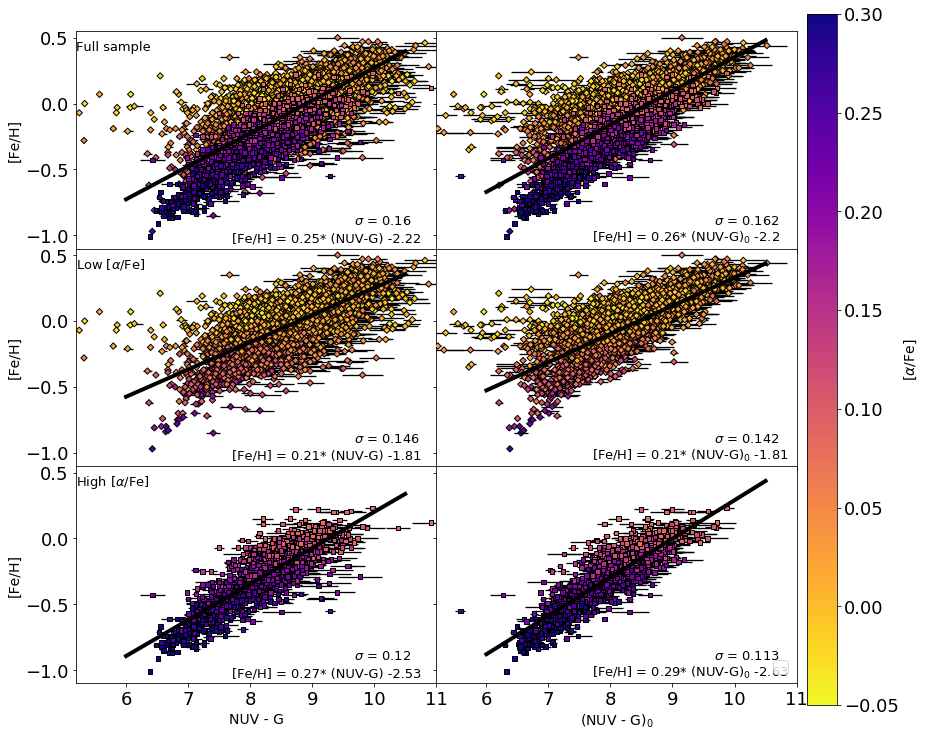

In [6]:
# Plot everything!

fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, sharex=True, sharey=True)

# Plotting with no dust correction first
# No dust, all points
cmap = ax1.scatter(xa[thin], y[thin], c=rc['ALPHAFE'][thin], s=20, vmin=-0.05, vmax=0.3, marker='D', edgecolor='black', cmap=cm.plasma_r, **{"zorder":5})
ax1.errorbar(xa[thin], y[thin], xerr =nuvgerr[thin], yerr=rc['FE_H_ERR'][thin], ecolor='black', fmt='None', marker='None', mew=0, elinewidth=1.3, **{"zorder":0})

ax1.scatter(xa[thick], y[thick], c=rc['ALPHAFE'][thick], s=20, vmin=-0.05, vmax=0.3, marker='s', edgecolor='black', cmap=cm.plasma_r, **{"zorder":5})
ax1.errorbar(xa[thick], y[thick], xerr =nuvgerr[thick], yerr=rc['FE_H_ERR'][thick], ecolor='black', fmt='None', marker='None', mew=0, elinewidth=1.3, **{"zorder":0})

ax1.plot(xp, pa(xp), linewidth=4, c='black', zorder=10) 


# Dust, all points
ax2.scatter(xb[thin], y[thin], c=rc['ALPHAFE'][thin], s=20, vmin=-0.05, vmax=0.3, marker='D', edgecolor='black', cmap=cm.plasma_r, **{"zorder":5})
ax2.errorbar(xb[thin], y[thin], xerr =nuvgerr[thin], yerr=rc['FE_H_ERR'][thin], ecolor='black', fmt='None', marker='None', mew=0, elinewidth=1.3, **{"zorder":0})

ax2.scatter(xb[thick], y[thick], c=rc['ALPHAFE'][thick], s=20, vmin=-0.05, vmax=0.3, marker='s', edgecolor='black', cmap=cm.plasma_r, **{"zorder":5})
ax2.errorbar(xb[thick], y[thick], xerr =nuvgerr[thick], yerr=rc['FE_H_ERR'][thick], ecolor='black', fmt='None', marker='None', mew=0, elinewidth=1.3, **{"zorder":0})

ax2.plot(xp, pb(xp), linewidth=4, c='black', zorder=10)


# No dust, thin disk
ax3.scatter(xa[thin], y[thin], c=rc['ALPHAFE'][thin], s=20, vmin=-0.05, vmax=0.3, marker='D', edgecolor='black', cmap=cm.plasma_r, **{"zorder":5})
ax3.errorbar(xa[thin], y[thin], xerr =nuvgerr[thin], yerr=rc['FE_H_ERR'][thin], ecolor='black', fmt='None', marker='None', mew=0, elinewidth=1.3, **{"zorder":0})

ax3.plot(xp, pathin(xp), linewidth=4, c='black', zorder=10)


# Dust, thin disk
ax4.scatter(xb[thin], y[thin], c=rc['ALPHAFE'][thin], s=20, vmin=-0.05, vmax=0.3, marker='D', edgecolor='black', cmap=cm.plasma_r, **{"zorder":5})
ax4.errorbar(xb[thin], y[thin], xerr =nuvgerr[thin], yerr=rc['FE_H_ERR'][thin], ecolor='black', fmt='None', marker='None', mew=0, elinewidth=1.3, **{"zorder":0})

ax4.plot(xp, pbthin(xp), linewidth=4, c='black', zorder=10)


# No dust, thick disk
ax5.scatter(xa[thick], y[thick], c=rc['ALPHAFE'][thick], s=20, vmin=-0.05, vmax=0.3, marker='s', edgecolor='black', cmap=cm.plasma_r, **{"zorder":5})
ax5.errorbar(xa[thick], y[thick], xerr =nuvgerr[thick], yerr=rc['FE_H_ERR'][thick], ecolor='black', fmt='None', marker='None', mew=0, elinewidth=1.3, **{"zorder":0})

ax5.plot(xp, pathick(xp), linewidth=4, c='black', zorder=10)


# Dust, thick disk
ax6.scatter(xb[thick], y[thick], c=rc['ALPHAFE'][thick], s=20, vmin=-0.05, vmax=0.3, marker='s', edgecolor='black', cmap=cm.plasma_r, **{"zorder":5})
ax6.errorbar(xb[thick], y[thick], xerr =nuvgerr[thick], yerr=rc['FE_H_ERR'][thick], ecolor='black', fmt='None', marker='None', mew=0, elinewidth=1.3, **{"zorder":0})

ax6.plot(xp, pbthick(xp), linewidth=4, c='black', zorder=10)


ax5.set_xlabel('NUV - G', fontsize=14)
ax6.set_xlabel('(NUV - G)$_{0}$', fontsize=14)
ax1.set_ylabel('[Fe/H]', fontsize=14)
ax3.set_ylabel('[Fe/H]', fontsize=14)
ax5.set_ylabel('[Fe/H]', fontsize=14)
ax6.legend(scatterpoints=1, loc="lower right")
ax1.set_xlim(5.19, 11)
ax1.set_ylim(-1.1,0.55)
fig.subplots_adjust(wspace=0)
fig.subplots_adjust(right=.84)
cbar_ax = fig.add_axes([0.85, 0.1, 0.03, 0.8])

ax1.annotate('[Fe/H] = '+str(np.round(za[0], 2))+'* (NUV-G) '+str(np.round(za[1],2)), xy=(7.7, -1.05), color='black',size=13)
ax1.annotate('$\sigma$ = '+str(round(aerr, 3)), xy=(9.67, -0.92), color='black', size=13)

ax2.annotate('[Fe/H] = '+str(np.round(zb[0], 2))+'* (NUV-G)$_0$ '+str(np.round(zb[1],2)), xy=(7.7, -1.05), color='black', size=13)
ax2.annotate('$\sigma$ = '+str(round(berr, 3)), xy=(9.67, -0.92), color='black', size=13)

ax3.annotate('[Fe/H] = '+str(np.round(zathin[0], 2))+'* (NUV-G) '+str(np.round(zathin[1],2)), xy=(7.7, -1.05), color='black', size=13)
ax3.annotate('$\sigma$ = '+str(round(athinerr, 3)), xy=(9.67, -0.92), color='black', size=13)

ax4.annotate('[Fe/H] = '+str(np.round(zbthin[0], 2))+'* (NUV-G)$_0$ '+str(np.round(zbthin[1],2)), xy=(7.7, -1.05), color='black', size=13)
ax4.annotate('$\sigma$ = '+str(round(bthinerr, 3)), xy=(9.67, -0.92), color='black', size=13)

ax5.annotate('[Fe/H] = '+str(np.round(zathick[0], 2))+'* (NUV-G) '+str(np.round(zathick[1],2)), xy=(7.7, -1.05), color='black', size=13)
ax5.annotate('$\sigma$ = '+str(round(athickerr, 3)), xy=(9.67, -0.92), color='black', size=13)

ax6.annotate('[Fe/H] = '+str(np.round(zbthick[0], 2))+'* (NUV-G)$_0$ '+str(np.round(zbthick[1],2)), xy=(7.7, -1.05), color='black', size=13)
ax6.annotate('$\sigma$ = '+str(round(bthickerr, 3)), xy=(9.67, -0.92), color='black', size=13)

ax1.annotate('Full sample', xy=(5.2, 0.4), size=13)
ax3.annotate(r'Low [$\alpha$/Fe]', xy=(5.2, 0.4), size=13)
ax5.annotate(r'High [$\alpha$/Fe]', xy=(5.2, 0.4), size=13)
fig.subplots_adjust(hspace=0, wspace=0)
fig.colorbar(cmap, cax=cbar_ax).set_label(r'[$\alpha$/Fe]', fontsize=14)
plt.show()
